## Notes

## 1. RAG application using gemini model api

In [20]:
# !pip install -qU langchain-google-genai
# !pip install python-dotenv
# !pip install -qU langchain-core
# !pip install langchain-ollama 

In [21]:
import langchain
from dotenv import load_dotenv
import os
load_dotenv()

True

In [22]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = os.getenv("langchain_api_key")
os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")

In [23]:
# Load the LLM model for the generation
from langchain_ollama import ChatOllama
llm = ChatOllama(
    model="llama3.1",
    temperature=0,
)

In [24]:
# Prepare the embedding model for the vector similarity search
from langchain_google_genai import GoogleGenerativeAIEmbeddings
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

### 1.1 Selecting the vector store - We will try with the in-memory vector store of langchain

In [25]:
from langchain_core.vectorstores import InMemoryVectorStore
vector_store_1 = InMemoryVectorStore(embeddings)

### 1.2 Document Indexing

In [26]:
import bs4
from langchain_community.document_loaders import WebBaseLoader
bs4_strainer = bs4.SoupStrainer(class_=("post"))

#### 1.2.1 Loading the document

In [27]:
loader = WebBaseLoader(web_path="https://jalammar.github.io/illustrated-transformer/",
                        bs_kwargs={"parse_only": bs4_strainer}
                        )
docs = loader.load()

In [28]:
assert len(docs) == 1
print(f"Total characters: {len(docs[0].page_content)}")
print(docs[0].page_content[:500])

Total characters: 24876

The Illustrated Transformer

Discussions:
Hacker News (65 points, 4 comments), Reddit r/MachineLearning (29 points, 3 comments)


Translations: Arabic, Chinese (Simplified) 1, Chinese (Simplified) 2, French 1, French 2, Italian, Japanese, Korean, Persian, Russian, Spanish 1, Spanish 2, Vietnamese

Watch: MIT’s Deep Learning State of the Art lecture referencing this post

Featured in courses at Stanford, Harvard, MIT, Princeton, CMU and others





Update: This post has now become a book! Check 


#### 1.2.2 Split the document into chunks

In [29]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
split_chunks = text_splitter.split_documents(docs)

print(f"Split blog post into {len(split_chunks)} sub-documents.")

Split blog post into 37 sub-documents.


#### 1.2.3 Store and index the document chunks in the vector store

In [30]:
document_ids = vector_store_1.add_documents(documents=split_chunks)
print(document_ids[:3])

['c4c7fa9d-361f-49de-9de3-7686cb3ee869', '014ba096-0f57-475a-8bfd-6c4c310d4a58', 'f85e7cc8-11b1-4dac-a59a-e85680edc8e2']


### 1.3 Preparing the rag prompt

In [31]:
from langchain_core.prompts import PromptTemplate

In [32]:
rag_prompt = PromptTemplate.from_template("""You are an assistant for question-answering tasks. Use the following piecesofretrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:
""")

print(rag_prompt.invoke({"question":"This is a user question","context":"This is a sample context"}))

text="You are an assistant for question-answering tasks. Use the following piecesofretrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: This is a user question \nContext: This is a sample context \nAnswer:\n"


### 1.4 Preparing the RAG pipeline

In [33]:
from typing_extensions import TypedDict,List
from langchain_core.documents import Document

class State(TypedDict):
    question: str
    context: List[Document]
    llm_response: str

In [34]:
def retrieve(state:State):
    user_query = state["question"]
    retrieved_contents = vector_store_1.similarity_search(user_query)
    return {"context":retrieved_contents}

In [35]:
def generate(state:State):
    user_query = state["question"]
    retrieved_contents = state["context"]
    document_content = "\n\n".join(i.page_content for i in state["context"])
    rag_message = rag_prompt.invoke({"question":user_query,"context":document_content})
    llm_response = llm.invoke(rag_message).content
    return {"llm_response":llm_response}


### 1.5 Initiate the Graph

In [36]:
# !pip install langgraph

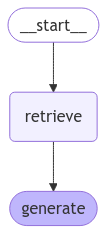

In [37]:
from langgraph.graph import START, StateGraph
from IPython.display import Image, display

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile() 

display(Image(graph.get_graph().draw_mermaid_png()))

In [38]:
result = graph.invoke({"question":"what is self attention?"})
print(f'LLM Response: {result["llm_response"]}') 

LLM Response: Self-attention allows a model to associate words with other positions in the input sequence for better encoding. When processing each word, self-attention looks at other positions for clues that can help lead to a better encoding. The "query", "key", and "value" vectors are abstractions used to calculate attention, where the query vector is used to score against key vectors of other words.


In [39]:
result = graph.invoke({"question":"What are the different components in a decoder module?"})
print(f'LLM Response: {result["llm_response"]}') 

LLM Response: A decoder module consists of multiple sub-layers, including self-attention layers and encoder-decoder attention layers. Each sub-layer in the decoder is identical in structure to those in the encoder, but with some modifications for the decoding phase. The final layer is a Linear layer followed by a Softmax Layer that converts the output vector into a word.
